# `strymread` tutorial
## Analyzing CAN data logged from Giraffee and Panda

### Prerequisite
- Install strym package from git: `pip install git+https://github.com/jmscslgroup/strym.git`
A detailed instruction about installation is available at https://github.com/jmscslgroup/strym/blob/master/README.md

In [1]:
import strym
from strym import strymread
from strym import ranalyze
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
import strym.DBC_Read_Tools as dbc
import numpy as np
from scipy.interpolate import interp1d
plt.rcParams["figure.figsize"] = (16,8)
rcParams.update({'font.size': 40})
dbcfile = '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc'
r =strymread(csvfile="/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_02_18/2020-02-18-13-00-42-209119__CAN_Messages.csv", dbcfile=dbcfile)


## We will visualize the counts of all messages
The plot is split into several subplots for brevity.

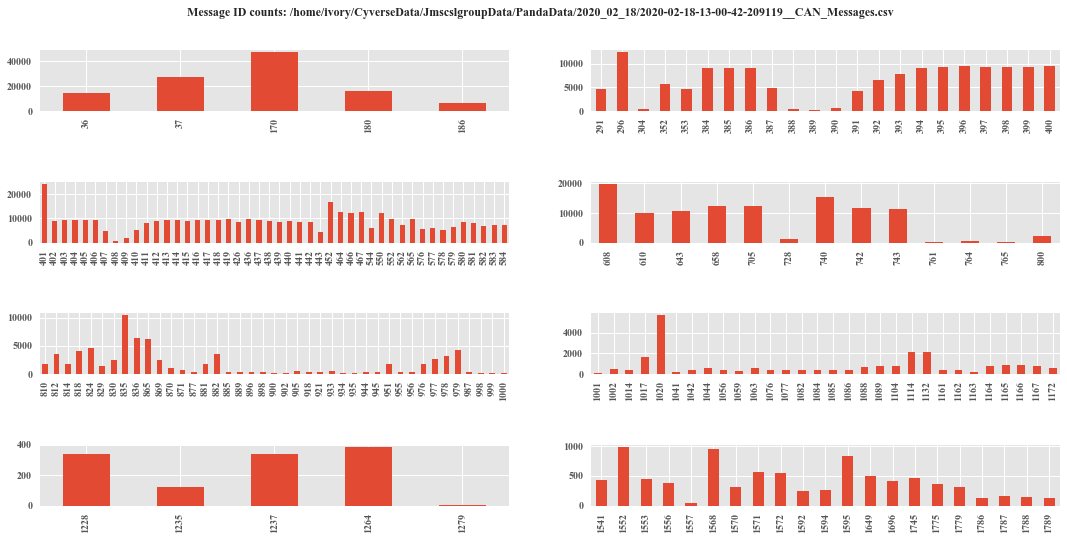

In [2]:
r.count()

## Let's plot a few important data
### Speed

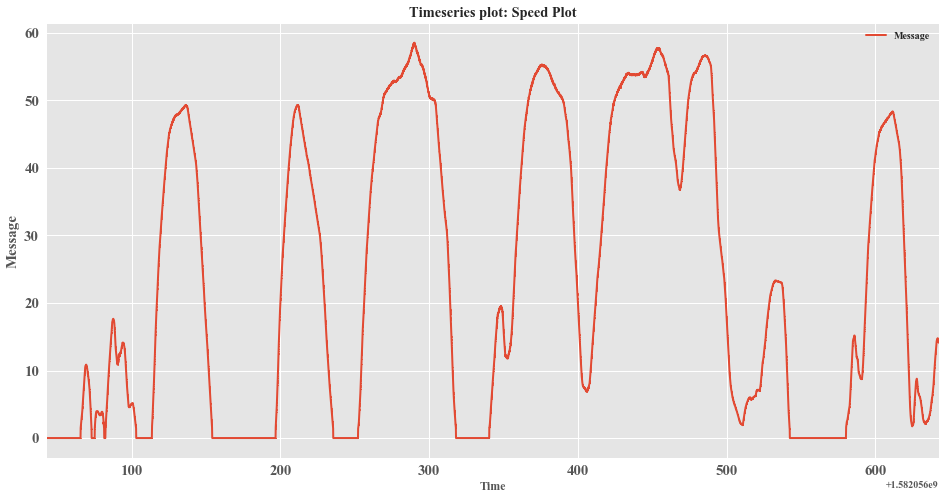

In [3]:
speed = r.speed()
strym.plt_ts(speed, title="Speed Plot")

## Rate Statistics for every message ID

In [4]:
u = r.frequency()
u

,MessageID,MeanRate,MedianRate,RateStd,MaxRate,MinRate,RateIQR
0,36,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
1,37,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
2,170,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
3,180,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
4,186,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
...,...,...,...,...,...,...,...
178,1779,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
179,1786,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
180,1787,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
181,1788,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221


## Synchronize Two Time Series messages and resample with a fixed datarate


It means first time of speed is earlier than yaw in time-series data so we have to interpolate speed value at yaw's first time. We will use linear interpolation.

Linear interpolation formula is 

$$
X_i = \cfrac{X_A - X_B}{a-b}(i-b) + X_B
$$

In [5]:
ts_yaw_rate = r.yaw_rate()
ts_speed = r.speed()

# integrate yaw rate to get the heading
ts_yaw = strym.integrate(ts_yaw_rate)

In [6]:
interpolated_speed, interpolated_yaw = strym.ts_sync(ts_speed, ts_yaw)

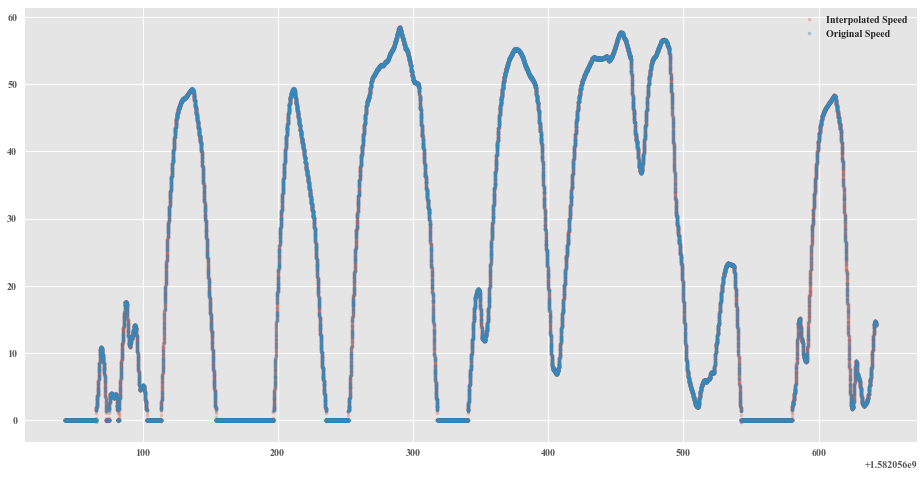

In [7]:
plt.plot(interpolated_speed['Time'], interpolated_speed['Message'], ".", alpha=0.3)
plt.plot(ts_speed['Time'], ts_speed['Message'], ".", alpha=0.4)
plt.legend(['Interpolated Speed', 'Original Speed'])

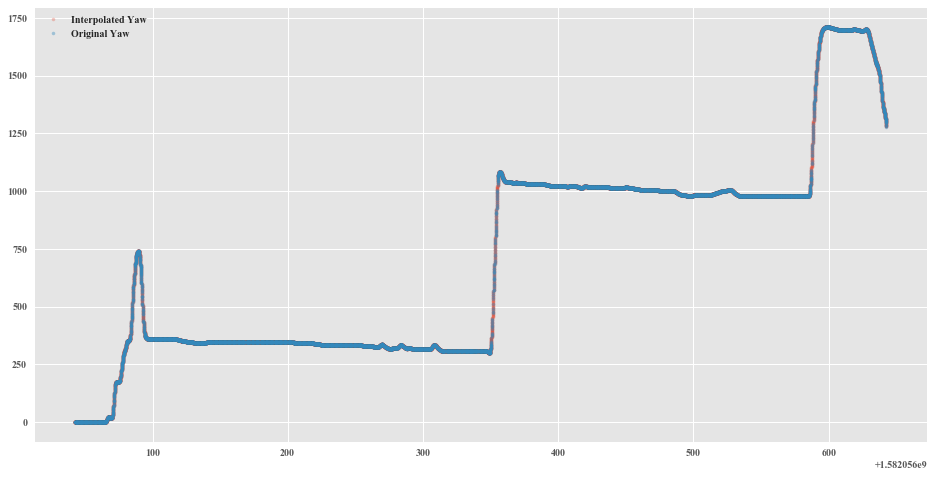

In [8]:
plt.plot(interpolated_yaw['Time'], interpolated_yaw['Message'], ".", alpha=0.3)
plt.plot(ts_yaw['Time'], ts_yaw['Message'], ".", alpha=0.4)
plt.legend(['Interpolated Yaw', 'Original Yaw'])

## Plot the trajectory of vehice based on kinematic model using yaw rate and speed

In [9]:
T = r.trajectory()

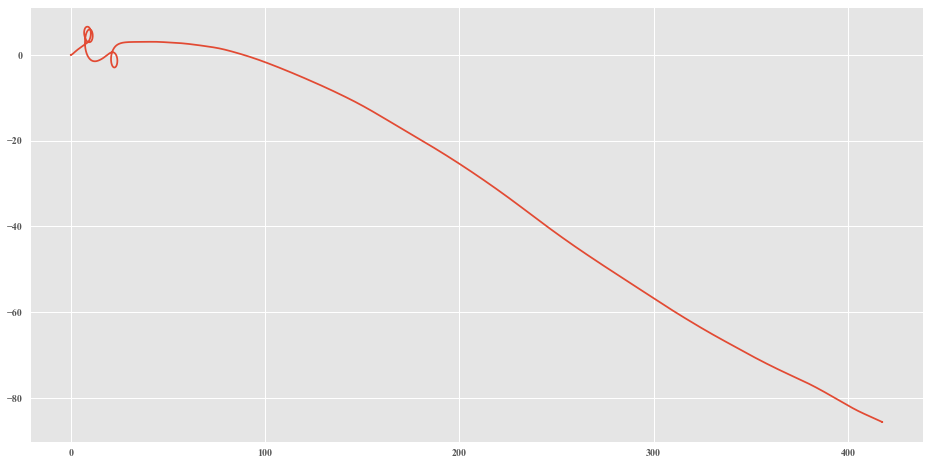

In [10]:
plt.plot(T['X'].iloc[1:7501], T['Y'].iloc[1:7501])

In [11]:
T[1:7500]

,Time,X,Y,Vx,Vy
1,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
2,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
3,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
4,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
5,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...
7495,1.582056e+09,417.701559,-85.615588,-4.406514e-79,9.035949e-80
7496,1.582056e+09,417.701559,-85.615588,8.306864e-79,-1.703396e-79
7497,1.582056e+09,417.701559,-85.615588,-2.992949e-78,6.137309e-79
7498,1.582056e+09,417.701559,-85.615588,1.100858e-77,-2.257407e-78


## Get the meta data about driving 

In [12]:
metadata = r.driving_characteristics()

In [13]:
metadata

{'filename': '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_02_18/2020-02-18-13-00-42-209119__CAN_Messages.csv',
 'dbcfile': '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc',
 'distance_meters': 3937.1090472204933,
 'distance_km': 3.9371090472204933,
 'distance_miles': 2.4464122231601113,
 'start_time': 'Tue Feb 18 13:00:42 2020',
 'end_time': 'Tue Feb 18 13:10:42 2020',
 'trip_time': 600.1924126148224}

## Get the distribution of data
### We will show the distribution of speed data

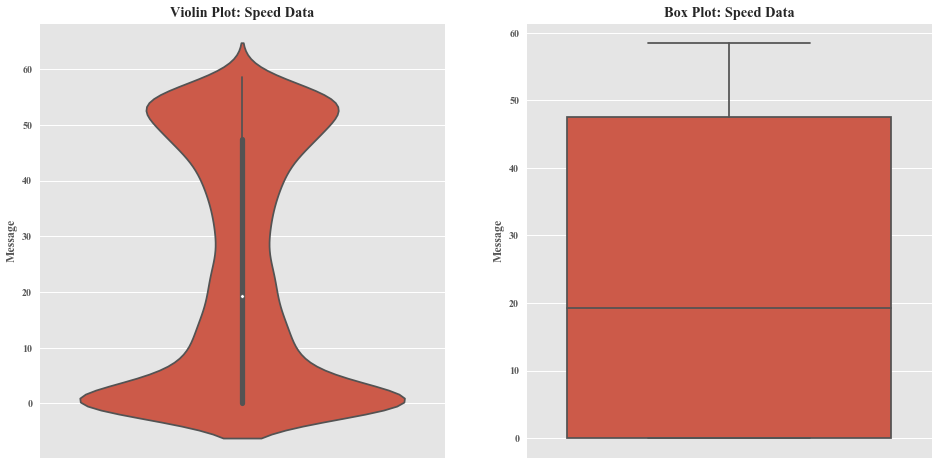

In [21]:
speed = r.speed()
strym.violinplot(speed['Message'], title="Speed Data")

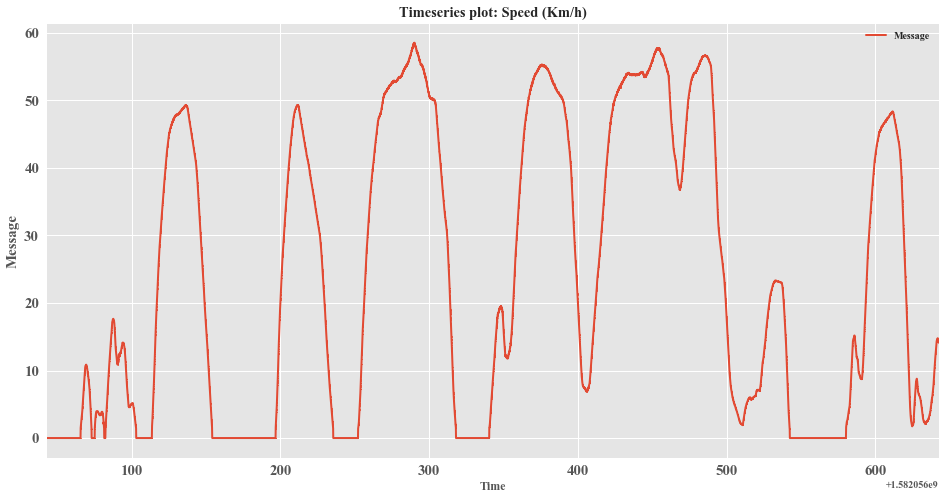

In [22]:
strym.plt_ts(speed, title='Speed (Km/h)')

## Rate Analysis for specific messages
Let's say we want to analyze data throughput aka rate for Radar data.
For this specific example, we will be looking at TRACK_A_0. For that we will call the appropriate function to retreive longitudinal data corresponding to TRACK_A_0.

Analyzing Timestamp and Data Rate of Longitudinal Distance Data: TRACK A 0
Interquartile Range of Rate for Longitudinal Distance Data: TRACK A 0 is 10.065492882674468 


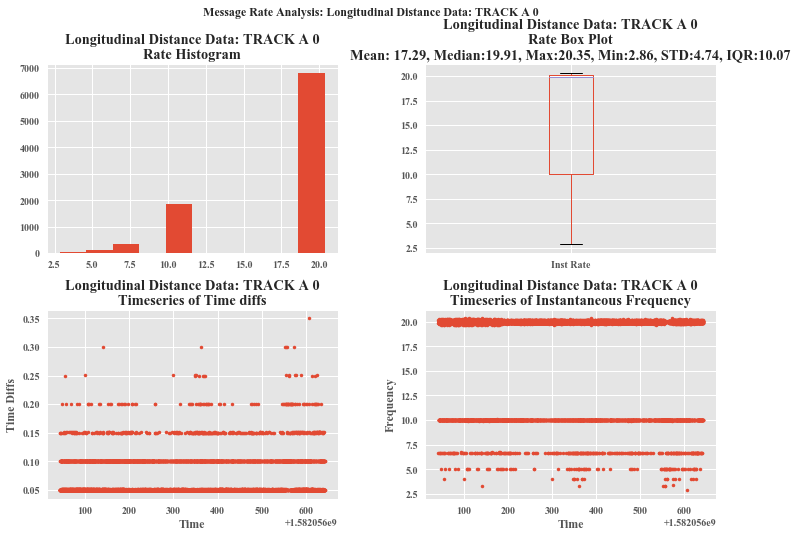

In [25]:
track_id = np.arange(0, 1) # I want to analyze rate for TRACK_A_0 only
long_dist = r.long_dist(track_id)

strym.ranalyze(long_dist, title='Longitudinal Distance Data: TRACK A 0')